In [1]:
import pandas as pd
from utils.text import plot_wordclouds
import seaborn as sns

In [2]:
binary=False

# Carregando dados de análise

In [3]:
data_df = pd.read_csv("/home/kenzosaki/mestrado/data/tweetsentbr/tweetsentbr_test.csv", index_col=0)

In [4]:
id2label = {
    0: "neutro",
    1: "positivo",
    2: "negativo"
}

In [5]:
# Convertendo ids para labels para facilitar interpretação
data_df["label"] = data_df["label"].map(id2label)

In [6]:
data_df.head()

,label,text
2403,positivo,Começou o The Noite com o Charlie Hunnam
1349,negativo,"No twitter a 3ª feira é chata,pois todo mundo ..."
5422,neutro,Bial declamando os do garçom Conversa Com Bial
1262,neutro,AI MEU DEUS É AGORA Master Chef BR
5438,negativo,A Miriam só não roda pq eu acho que o tal sorv...


In [7]:
# Para focar a análise em apenas duas classes: positivo e negativo
if binary:
    data_df = data_df[data_df["label"] != "neutro"]

# Definindo procedimento de pre-processamento de texto

Pipeline simples de pre-processamento de texto, incluindo: conversão para lower-case, remoção de stop-words, remoção de hashtags e lemmatização. Feito o processamento, o documento é convertido para uma representação densa utilizando *word embeddings*. O spaCy utiliza embeddings FastText de 300 dimensões para representar seus tokens. Assim, textos serão representados por 300 dimensões, que correspondem a média das *word embeddings* dos seus tokens. 

- Obs: Tokens que não estão no vocabulário das embeddings pre-treinadas são representadas como vetores de zeros.

In [8]:
import spacy
import numpy as np
nlp = spacy.load("pt_core_news_md")

In [9]:
t = nlp("qdhiuweui frase de teste")

In [11]:
a.vector

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [12]:
from typing import Iterable

def convert_text_to_vector(text: str) -> Iterable[str]:

    tokens = nlp(text)

    text_vector = np.zeros(300)
    used_tokens = 0

    for token in tokens:

        lemma = token.lemma_

        if token.is_stop: continue              # remoção de stop-words
        if token.is_punct: continue             # remoção de pontuação
        if len(lemma.strip()) == 0: continue    # ignorar tokens "vazios"
        if "@" in lemma: continue               # remoção simples de hashtags

        text_vector += token.vector
        used_tokens += 1
    
    return text_vector / used_tokens

# Conversão dos textos para representações densas

In [13]:
from sklearn.preprocessing import normalize

In [14]:
# Conversão para representações densas
text_vectors = [convert_text_to_vector(text) for text in data_df["text"]]

In [28]:
# Normalização L2 para geração de vetores unitários
text_vectors = normalize(text_vectors)

# Agrupamento usando K-means

In [29]:
from sklearn.cluster import KMeans
from tqdm import tqdm

In [30]:
# Quantidades de clusters para avaliar
n_clusters = list(range(2,11))
n_clusters

[2, 3, 4, 5, 6, 7, 8, 9, 10]

In [31]:
fitted_models = []
for k in tqdm(n_clusters):
    
    kmeans = KMeans(n_clusters=k, n_init=100, init='random', max_iter=500)
    kmeans.fit(text_vectors)

    fitted_models.append(kmeans)

100%|██████████| 9/9 [00:11<00:00,  1.28s/it]


# Avaliando silhueta dos agrupamentos gerados

In [32]:
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster.silhouette import silhouette_visualizer
import numpy as np
import matplotlib.pyplot as plt

In [33]:
%matplotlib inline

In [34]:
sns.set(rc={'figure.figsize':(15,6)})

In [35]:
silhouettes = [silhouette_score(text_vectors, kmeans.labels_) for kmeans in fitted_models]
inertias = [kmeans.inertia_ for kmeans in fitted_models]

Text(0.5, 0, 'Number of clusters')

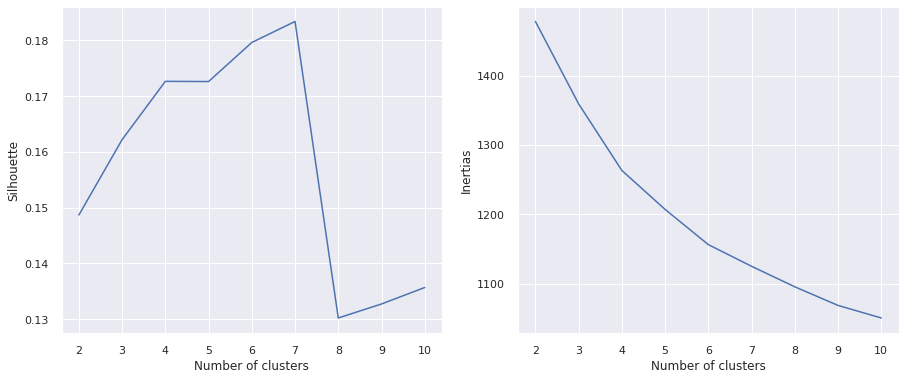

In [36]:
fig, axes = plt.subplots(1,2)

ax = sns.lineplot(x=n_clusters, y=silhouettes, ax=axes[0])
ax.set_ylabel("Silhouette")
ax.set_xlabel("Number of clusters")

ax = sns.lineplot(x=n_clusters, y=inertias, ax=axes[1])
ax.set_ylabel("Inertias")
ax.set_xlabel("Number of clusters")

In [37]:
# Escolhendo o modelo de maior silhueta mpedia para análise
kmeans = fitted_models[np.argmax(silhouettes)]

In [38]:
data_df["silhouette"] = silhouette_samples(text_vectors, kmeans.labels_)
data_df["cluster"] = kmeans.labels_

In [39]:
mean_silh = data_df["silhouette"].mean()

In [40]:
print(f"- EE: {kmeans.inertia_}")
print(f"- Mean silhouette: {mean_silh}")

- EE: 1124.8796182801818
- Mean silhouette: 0.1833810935051064


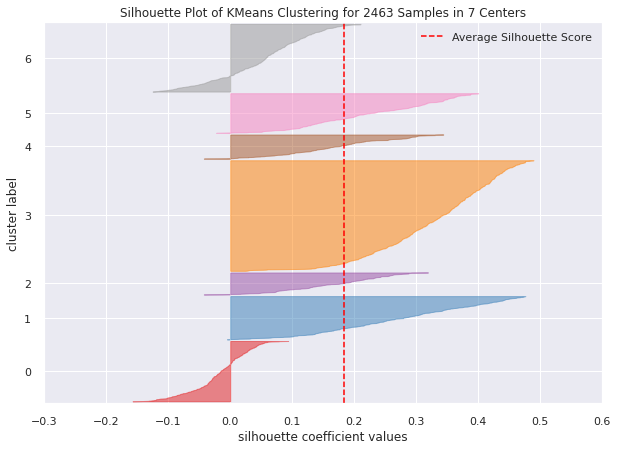

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d2cc70cd0>,
                     estimator=KMeans(init='random', max_iter=500, n_clusters=7,
                                      n_init=100))

In [41]:
sns.set(rc={'figure.figsize':(10,7)})
silhouette_visualizer(
    kmeans,
    X=text_vectors,
    y=data_df["label"].values,
    is_fitted=True
)

# Comparação entre clusters

Comparando pares de clusters, com relação as classes (positivo, neutro ou negativo) e palavras frequentes.

In [51]:
cluster_pair = (1, 3)

In [52]:
c0_df = data_df[data_df["cluster"] == cluster_pair[0]]
c1_df = data_df[data_df["cluster"] == cluster_pair[1]]

# Distribuição de classes por cluster

In [53]:
order = ["positivo", "negativo"] if binary else \
        ["positivo", "neutro", "negativo"]

Text(0.5, 0, 'Cluster 3')

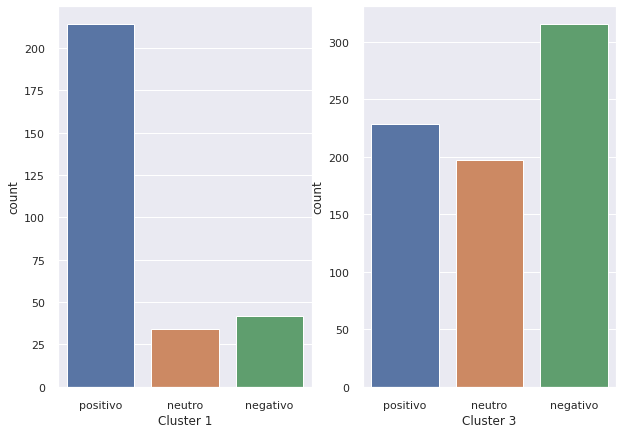

In [54]:
fig, axes = plt.subplots(1,2)

sns.countplot(data=c0_df, x="label", ax=axes[0], order=order)
axes[0].set_xlabel(f"Cluster {cluster_pair[0]}")
sns.countplot(data=c1_df, x="label", ax=axes[1], order=order)
axes[1].set_xlabel(f"Cluster {cluster_pair[1]}")

## Wordclouds por cluster

Gerando nuvens de palavras para cluster do par em análise.

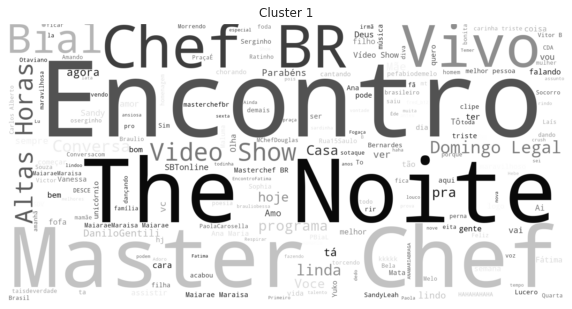

In [55]:
plot_wordclouds(
    text=" ".join(c0_df["text"].values.tolist()),
    title=f"Cluster {cluster_pair[0]}",
    colormap="binary", 
    background_color='white',
    max_words=200,
    width=1600, height=800
)

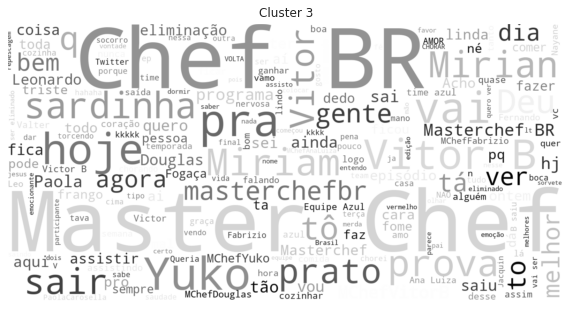

In [56]:
plot_wordclouds(
    text=" ".join(c1_df["text"].values.tolist()),
    title=f"Cluster {cluster_pair[1]}",
    colormap="binary", 
    background_color='white',
    max_words=200,
    width=1600, height=800
)

# Visualizando exemplos de maior silhueta por cluster

In [57]:
cluster = 1

In [58]:
c_df = data_df[data_df["cluster"] == cluster]

In [59]:
pd.set_option('max_colwidth', None)
c_df.sort_values(by="silhouette", ascending=False).head(10)

,label,text,silhouette,cluster
517,positivo,encontro anos só de carreira. É muito talento. É muita história 😍😍😍😍😍😍😍😍😍😍😍😍,0.476102,1
9420,positivo,"""Eu quero descer!!!"" 😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂 The Noite",0.474250,1
8878,neutro,São muito lokas!!!!!!!! 😂😂😂😂😂😂😂 Conversa Com Bial,0.473854,1
982,positivo,Que show de violino no Encontro 👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻,0.473174,1
9115,positivo,Coisa mais linda essa edição com a mãe do @oserginho !!!!! 😍😍😍😍💗💗💗💗altas horas,0.472538,1
1322,positivo,Esses caras do The Noite são foda 😂😂😂😂😂😂😂😂😂😂😂😂,0.471367,1
897,positivo,O Diguinho sensualizando com a perna 😂😂😂😂😂😂😂😂😂 The Noite Mestre Mandou,0.467986,1
9427,positivo,😂😂😂😂😂😂😂😂 gosto quando o programa é ao vivo e tem conflitos!!! Encontro,0.467848,1
5028,positivo,O Léo carregando o Danilo 😂😂😂😂😂😂😂😂😂😂 The Noite,0.466079,1
4243,positivo,"Ana Maria Braga, melhor pessoa 😂😂😂😂😂😂😂😂 Mais Voce",0.462968,1
